In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
import dask
from dask_jobqueue import PBSCluster 

# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-worker',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    log_directory ='/glade/derecho/scratch/wwieder/temp/dask-scratch-space',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '1:30:00',
    interface = 'ext',
    job_extra_directives=['-m n']
)

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33689 instead
  warnings.warn(


In [3]:
# Next, print the job script for our debugging: 
print(cluster.job_script()) 


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A P93300041
#PBS -l select=1:ncpus=1:mem=4GB
#PBS -l walltime=1:30:00
#PBS -e /glade/derecho/scratch/wwieder/temp/dask-scratch-space/
#PBS -o /glade/derecho/scratch/wwieder/temp/dask-scratch-space/
#PBS -m n

/glade/u/apps/opt/conda/envs/npl-2023b/bin/python -m distributed.cli.dask_worker tcp://128.117.208.96:34815 --nthreads 1 --memory-limit 4.00GiB --name dummy-name --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [4]:
# Add a client and scale up:
from dask.distributed import Client
client = Client(cluster)
client 

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/33689/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/33689/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:34815,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/NewLogin/proxy/33689/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# Scale the cluster to n workers
cluster.scale(20)

In [6]:
#plat, plon, site = 38.9592, (360-106.9898), 'gothic' #coords for RMBL in Gothic
#plat, plon, site = 39.05, (360-106.9898), 'gothic2' #Move North a bit
plat, plon, site = 38.81, (360-106.9898), 'gothic3' #Move South a bit
#plat, plon, site = 38.9592, (360-106.87), 'gothic4' #Move East a bit
#plat, plon, site = 38.9592, (360-107.1), 'gothic5' #Move West a bit

def preprocess (ds, plat=plat, plon=plon):

    LATI=ds.LATIXY.isel(time=0,lon=0).values
    LONG=ds.LONGXY.isel(time=0,lat=0).values
    ds = ds.assign_coords({"lon": LONG, 'lat':LATI})
    ds_new = ds.sel(lat=plat,lon=plon, method='nearest')

    return ds_new

In [8]:
#fin = '/glade/p/cgd/tss/CTSM_datm_forcing_data/atm_forcing.datm7.NLDAS2.0.125d.v2.c200908/'
#files through 2022
fin = '/glade/campaign/cgd/tss/people/swensosc/NLDAS'
ftypes = ['Precip','Solar','TPQWL']
dir_in = 'clmforc.NLDAS2.c2020.0125x0125.'
years = ['200','201','202'] 
# Make this quick!
#ftypes = ['Solar']
#years = ['202'] 

#Can't combine datasets here because time intervals aren't the same, but unsure why for hourly data?
#out_dir = '/glade/derecho/scratch/wwieder/nldas/'+site+'/'
out_dir = '/glade/campaign/cgd/tss/people/wwieder/'+site+'/datm_nldas/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)            

for ftype in ftypes: 
    print('starting '+ftype)
    for year in years:
        # list of files
        files = []
        #files.extend(sorted(glob(join(fin,ftype+dir_in+ftype+"."+year+"*.nc"))))
        # For Sean's data through 2022
        files.extend(sorted(glob(join(fin,'*'+ftype+"."+year+"*.nc"))))

        # Open datasets
        ds = xr.open_mfdataset(files, decode_times=True, combine='by_coords',parallel=True)

        # Assign coords
        LATI=ds.LATIXY.isel(time=0,lon=0).values
        LONG=ds.LONGXY.isel(time=0,lat=0).values
        ds = ds.assign_coords({'lon': LONG, 'lat':LATI})

        # Subset data & modify fillValues
        ds = ds.sel(lat=plat,lon=plon, method='nearest')
        ds= ds.expand_dims(dim={"lat": 1},axis=1)
        ds= ds.expand_dims(dim={"lon": 1},axis=2)
        ds['LONGXY'] = ds['LONGXY'].isel(time=0)
        ds['LATIXY'] = ds['LATIXY'].isel(time=0)
        ds['time'].attrs['_FillValue'] = 1.e36
        ds['LONGXY'].attrs['_FillValue'] = 1.e36
        ds['LATIXY'].attrs['_FillValue'] = 1.e36
        ds['lat'].attrs['_FillValue'] = 1.e36
        ds['lon'].attrs['_FillValue'] = 1.e36
        print('...loading data...')
        ds = ds.persist() 
        _ = wait(ds)

        if year == '202':
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-2022_nc4.nc'
        else: 
            fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-'+str(int(year)*10+9)+'_nc4.nc'
        ds.to_netcdf(fout)
        print('wrote '+fout)

print("-- done! --")

starting Precip
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Precip.gothic3.2000-2009_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Precip.gothic3.2010-2019_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Precip.gothic3.2020-2022_nc4.nc
starting Solar
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic3.2000-2009_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic3.2010-2019_nc4.nc
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic3.2020-2022_nc4.nc
starting TPQWL
...loading data...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic3.2000-2009_nc4.nc
...loa

## Look at datm 

In [40]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic.2010-2019.nc',
                     decode_times=True)
ds3 = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic3.2010-2019.nc',
                       decode_times=True)
niwot = '/glade/campaign/cesm/cesmdata/inputdata/atm/datm7/CLM1PT_data/PLUMBER2/US-NR1/CLM1PT_data/CTSM_DATM_US-NR1_1999-2014.nc'
niwot = xr.open_mfdataset(niwot, decode_times=True).isel(lat=0,lon=0)
niwot.time

<xarray.DataArray 'time' (time: 280512)>
array(['1999-01-01T07:00:00.000000000', '1999-01-01T07:30:00.000000000',
       '1999-01-01T08:00:00.000000000', ..., '2015-01-01T05:29:52.000000000',
       '2015-01-01T06:00:16.000000000', '2015-01-01T06:30:08.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01T07:00:00 ... 2015-01-01T06:30:08
Attributes:
    long_name:  observation time

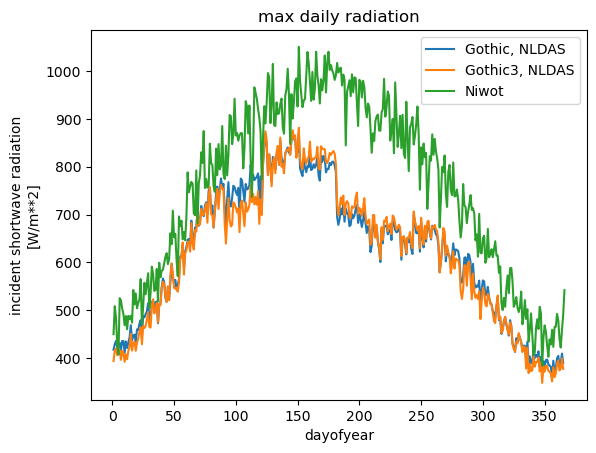

In [42]:
ds.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot.FSDS.resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.title('max daily radiation')
plt.legend() ;

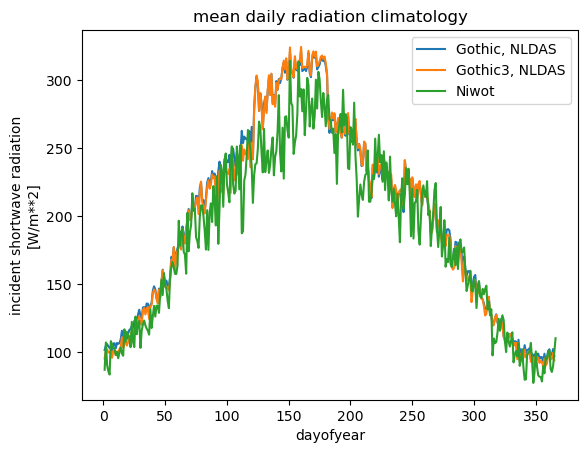

In [44]:
ds.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot.FSDS.resample(time="1D").mean().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.title('mean daily radiation climatology')
plt.legend() ;

In [45]:
niwot.FSDS.sel(time=niwot.time.dt.month.isin([5])).time[0:24]

<xarray.DataArray 'time' (time: 24)>
array(['1999-05-01T00:00:00.000000000', '1999-05-01T00:30:00.000000000',
       '1999-05-01T01:00:00.000000000', '1999-05-01T01:30:00.000000000',
       '1999-05-01T02:00:00.000000000', '1999-05-01T02:30:00.000000000',
       '1999-05-01T03:00:00.000000000', '1999-05-01T03:30:00.000000000',
       '1999-05-01T04:00:00.000000000', '1999-05-01T04:30:00.000000000',
       '1999-05-01T05:00:00.000000000', '1999-05-01T05:30:00.000000000',
       '1999-05-01T06:00:00.000000000', '1999-05-01T06:30:00.000000000',
       '1999-05-01T07:00:00.000000000', '1999-05-01T07:30:00.000000000',
       '1999-05-01T08:00:00.000000000', '1999-05-01T08:30:00.000000000',
       '1999-05-01T09:00:00.000000000', '1999-05-01T09:30:00.000000000',
       '1999-05-01T10:00:00.000000000', '1999-05-01T10:30:00.000000000',
       '1999-05-01T11:00:00.000000000', '1999-05-01T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1999-05-01 ... 1999-05-01T11:30:00
Attributes:
    long_name:  observation time

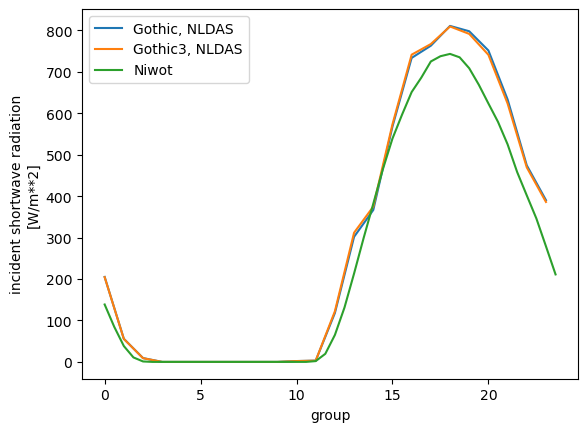

In [66]:
nmonth = 5
ndays = 31
nyears = 16

ds.FSDS.sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
ds3.FSDS.sel(time=ds3.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic3, NLDAS')

nwtPlot = niwot.FSDS.sel(time=niwot.time.dt.month.isin([nmonth]))
x = list((range(48)))*ndays*nyears #31 days for 16 years
x = np.array(x,dtype=float)
x = x/2
grouper = xr.DataArray(
    pd.Index(x),
    dims=['time'], coords=[nwtPlot.time],
)

nwtPlot.groupby(grouper).mean(dim='time').plot(label='Niwot')
plt.legend() ;

# May have to manually write these to nc5
nccopy -k cdf5 /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2020-2022.nc /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo2.c2020.Solar.gothic.2020-2022.nc

In [67]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic.2010-2019.nc',
                     decode_times=True)
ds3 = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic3/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic3.2010-2019.nc',
                       decode_times=True)

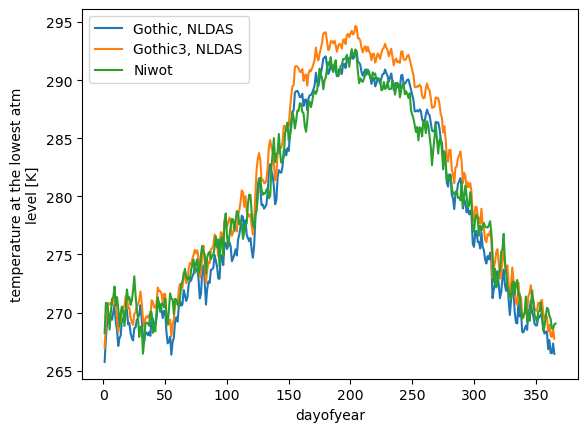

In [68]:
var = 'TBOT'
ds[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic, NLDAS')
ds3[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Gothic3, NLDAS')
niwot[var].resample(time="1D").max().groupby('time.dayofyear').mean().plot(label='Niwot')
plt.legend();


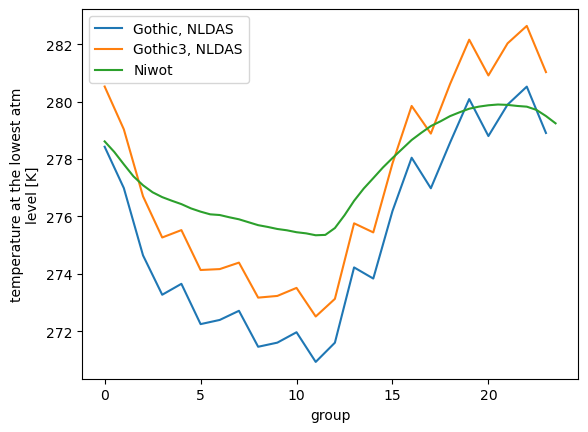

In [69]:
nmonth = 5
ndays = 31
nyears = 16

ds[var].sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
ds3[var].sel(time=ds3.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic3, NLDAS')

nwtPlot = niwot[var].sel(time=niwot.time.dt.month.isin([nmonth]))
x = list((range(48)))*ndays*nyears #31 days for 16 years
x = np.array(x,dtype=float)
x = x/2
grouper = xr.DataArray(
    pd.Index(x),
    dims=['time'], coords=[nwtPlot.time],
)

nwtPlot.groupby(grouper).mean(dim='time').plot(label='Niwot')
plt.legend() ;

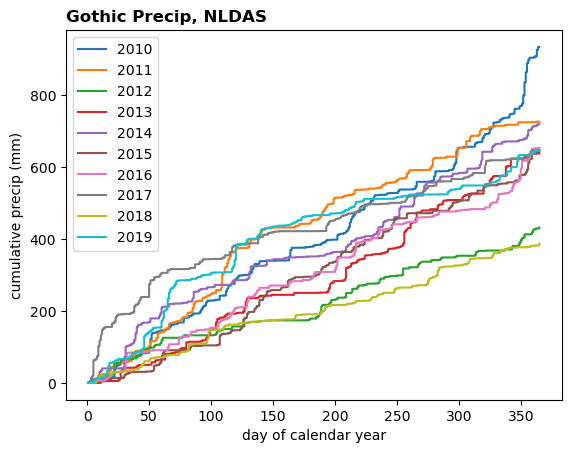

In [22]:
sph = 3600
cumPPT = ((ds.PRECTmms.groupby('time.year').cumsum())*sph)
cumPPT = cumPPT.isel(lat=0, lon=0)
for year in range(2010, 2020):
    plot = xr.where(cumPPT['time.year'] == year, cumPPT, np.nan)
    x = plot['time.dayofyear']
    y = plot
    plt.plot(x, y, label=str(year))

plt.legend()
plt.ylabel('cumulative precip (mm)')
plt.xlabel('day of calendar year')
plt.title('Gothic Precip, NLDAS', loc='left', fontsize='large', fontweight='bold') ;